# Implied Volatility Prediction

## 1. Import Libraries

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from scipy.interpolate import interp1d
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
%matplotlib inline

## 2. Load Data

In [2]:
# Load data
train = pd.read_parquet('train_data.parquet')
test = pd.read_parquet('test_data.parquet')
sample_sub = pd.read_csv('sample_submission.csv')

print("Training Data Shape:", train.shape)
print("Test Data Shape:", test.shape)
print("Sample Submission Shape:", sample_sub.shape)

print("\nTraining Data Head:")
display(train.head())

print("\nMissing Values in Training Data:")
display(train.isna().sum().sort_values(ascending=False).head(10))

Training Data Shape: (178340, 97)
Test Data Shape: (12065, 96)
Sample Submission Shape: (12065, 53)

Training Data Head:


,timestamp,underlying,expiry,call_iv_23500,call_iv_23600,call_iv_23700,call_iv_23800,call_iv_23900,call_iv_24000,call_iv_24100,...,X32,X33,X34,X35,X36,X37,X38,X39,X40,X41
0,1745296089000000000,24160.9,2025-04-24,0.237872,0.213056,0.191247,0.173081,0.157550,0.146430,0.140084,...,0.013995,0.007922,-1.947502e+05,0.024715,0.530894,-0.002354,-3.224848e+05,-1.600795e+06,13063.446970,445511.363636
1,1745304077000000000,24188.1,2025-04-24,0.236015,0.213177,0.189552,0.169672,0.153648,0.141522,0.134405,...,-0.004976,-0.009555,-1.481909e+06,-0.004020,-1.429919,-0.000843,1.658073e+06,-1.742468e+06,31364.628427,-46123.161765
2,1745313495000000000,24148.6,2025-04-24,0.225757,0.199469,0.178547,0.156187,0.140276,0.130288,0.124253,...,-0.012869,-0.004012,-1.250688e+06,-0.035342,-0.523109,0.013778,-2.646675e+06,-5.051008e+07,-847564.971737,-225333.881579
3,1745313499000000000,24147.4,2025-04-24,0.220805,0.195398,0.176247,0.155271,0.139753,0.129641,0.123994,...,-0.006014,0.004207,6.378700e+05,-0.045472,0.741664,0.002590,-1.607321e+06,4.170899e+05,333918.361928,-114960.453869
4,1745313608000000000,24155.9,2025-04-24,0.220088,0.195815,0.177803,0.156409,0.141458,0.130448,0.124707,...,0.020878,-0.001747,9.592702e+04,0.044814,-0.015472,0.012185,6.820360e+05,4.081106e+06,3309.895833,183946.289063



Missing Values in Training Data:


timestamp        0
underlying       0
expiry           0
call_iv_23500    0
call_iv_23600    0
call_iv_23700    0
call_iv_23800    0
call_iv_23900    0
call_iv_24000    0
call_iv_24100    0
dtype: int64

## 3. Prepare IV Columns

In [16]:
# Get the IV columns from sample submission (excluding timestamp)
sample_iv_cols = [col for col in sample_sub.columns if col != 'timestamp']

# Map sample submission columns to our dataset columns
iv_columns = []
for col in sample_iv_cols:
    if col in test.columns and col in train.columns:
        iv_columns.append(col)
    else:
        print(f"Warning: Column {col} from sample submission not found in dataset")

# Create strike dictionary from filtered columns
strike_dict = {}
for col in iv_columns:
    strike = col.split('_')[-1]
    if strike not in strike_dict:
        strike_dict[strike] = {'call': None, 'put': None}
    
    if col.startswith('call_iv_'):
        strike_dict[strike]['call'] = col
    else:
        strike_dict[strike]['put'] = col

print(f"Found {len(iv_columns)} IV columns matching sample submission format")
print(f"Found {len(strike_dict)} unique strikes")
print("\nStrike Dictionary Example:")
display({k: strike_dict[k] for k in list(strike_dict.keys())[:3]})

Found 42 IV columns matching sample submission format
Found 31 unique strikes

Strike Dictionary Example:


{'24000': {'call': 'call_iv_24000', 'put': 'put_iv_24000'},
 '24100': {'call': 'call_iv_24100', 'put': 'put_iv_24100'},
 '24200': {'call': 'call_iv_24200', 'put': 'put_iv_24200'}}

## 4. Calculate Global Statistics

Overall mean IV across all strikes: -12.4045

Global Stats Example:


{'call_iv_24000': {'mean': np.float64(1.5803173304391611),
  'std': np.float64(402.7997710415377)},
 'call_iv_24100': {'mean': np.float64(0.1952128715991925),
  'std': np.float64(0.05609654334987734)},
 'call_iv_24200': {'mean': np.float64(0.16099717636929461),
  'std': np.float64(0.032195505401451385)}}

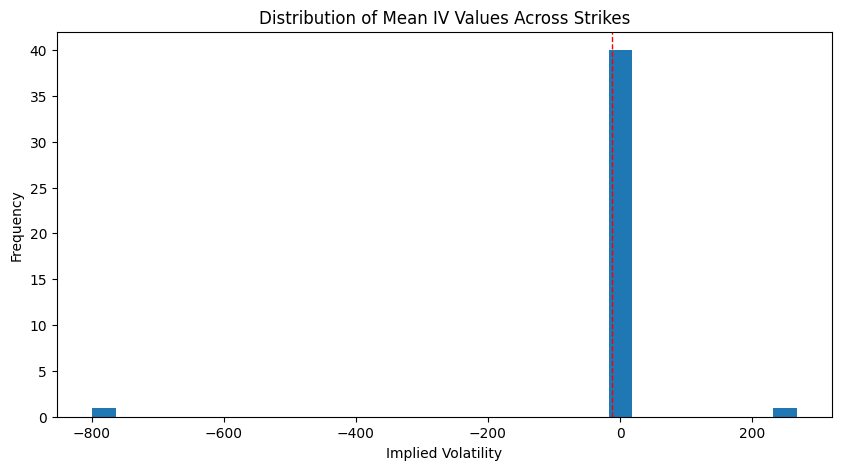

In [17]:
# Pre-calculate global means and standard deviations from training data
global_stats = {}
for col in iv_columns:
    if col in train.columns:
        global_stats[col] = {
            'mean': train[col].mean(),
            'std': train[col].std()
        }
overall_mean = np.mean([stats['mean'] for stats in global_stats.values()]) if global_stats else 0.2

print(f"Overall mean IV across all strikes: {overall_mean:.4f}")
print("\nGlobal Stats Example:")
display({k: global_stats[k] for k in list(global_stats.keys())[:3]})

# Plot distribution of means
plt.figure(figsize=(10, 5))
plt.hist([stats['mean'] for stats in global_stats.values()], bins=30)
plt.title('Distribution of Mean IV Values Across Strikes')
plt.xlabel('Implied Volatility')
plt.ylabel('Frequency')
plt.axvline(overall_mean, color='r', linestyle='dashed', linewidth=1)
plt.show()

## 5. Define Prediction Function

In [18]:
def extract_strike_price(strike_str):
    try:
        return float(strike_str)
    except:
        return 0.0

def predict_iv(data):
    data = data.copy()
    
    # Phase 1: Strict put-call parity
    for strike, cols in strike_dict.items():
        call_col = cols['call']
        put_col = cols['put']
        
        if call_col in data.columns and put_col in data.columns:
            # Fill calls using puts where possible
            call_mask = data[call_col].isna() & data[put_col].notna()
            data.loc[call_mask, call_col] = data.loc[call_mask, put_col]
            
            # Fill puts using calls where possible
            put_mask = data[put_col].isna() & data[call_col].notna()
            data.loc[put_mask, put_col] = data.loc[put_mask, call_col]
    
    # Phase 2: Time-based weighted mean imputation
    for idx, row in data.iterrows():
        # Get timestamp for this row
        current_time = row['timestamp']
        
        # Collect all available IV values in this row with their strikes
        available_ivs = []
        available_strikes = []
        
        for col in iv_columns:
            if col in row and not pd.isna(row[col]):
                strike = extract_strike_price(col.split('_')[-1])
                available_ivs.append(row[col])
                available_strikes.append(strike)
        
        if len(available_ivs) >= 2:
            # Create a dictionary to handle duplicate strikes
            strike_iv_dict = {}
            for strike, iv in zip(available_strikes, available_ivs):
                if strike not in strike_iv_dict:
                    strike_iv_dict[strike] = []
                strike_iv_dict[strike].append(iv)
            
            # Average IVs for duplicate strikes
            unique_strikes = []
            unique_ivs = []
            for strike in sorted(strike_iv_dict.keys()):
                unique_strikes.append(strike)
                unique_ivs.append(np.mean(strike_iv_dict[strike]))
            
            # Create interpolation function
            f = interp1d(unique_strikes, unique_ivs, kind='linear', bounds_error=False, fill_value='extrapolate')
            
            # Apply interpolation to missing values
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    strike = extract_strike_price(col.split('_')[-1])
                    interpolated_value = f(strike)
                    
                    # Ensure interpolated value is within reasonable bounds
                    if interpolated_value > 0 and interpolated_value < 1:
                        data.at[idx, col] = interpolated_value
                    else:
                        # Fallback to row mean if interpolation is unreasonable
                        data.at[idx, col] = np.mean(available_ivs)
        else:
            # If not enough points for interpolation, use row mean
            row_mean = np.mean(available_ivs) if available_ivs else overall_mean
            
            # Apply row mean to all missing IVs in this row
            for col in iv_columns:
                if col in data.columns and pd.isna(data.at[idx, col]):
                    data.at[idx, col] = row_mean
    
    # Phase 3: Smoothing to maintain volatility smile shape
    for idx, row in data.iterrows():
        for strike, cols in strike_dict.items():
            call_col = cols['call']
            put_col = cols['put']
            
            if call_col in data.columns and put_col in data.columns:
                # Calculate average of call and put IVs
                avg_iv = (data.at[idx, call_col] + data.at[idx, put_col]) / 2
                
                # Apply slight smoothing
                data.at[idx, call_col] = 0.95 * data.at[idx, call_col] + 0.05 * avg_iv
                data.at[idx, put_col] = 0.95 * data.at[idx, put_col] + 0.05 * avg_iv
    
    return data

## 6. Create Validation Split

In [19]:
# Create validation split
train_df, val_df = train_test_split(train, test_size=0.2, random_state=42)

print(f"Training split size: {train_df.shape}")
print(f"Validation split size: {val_df.shape}")


Training split size: (142672, 97)
Validation split size: (35668, 97)


## 7. Validate Model

Validation MSE (masked points only): 0.000000000000


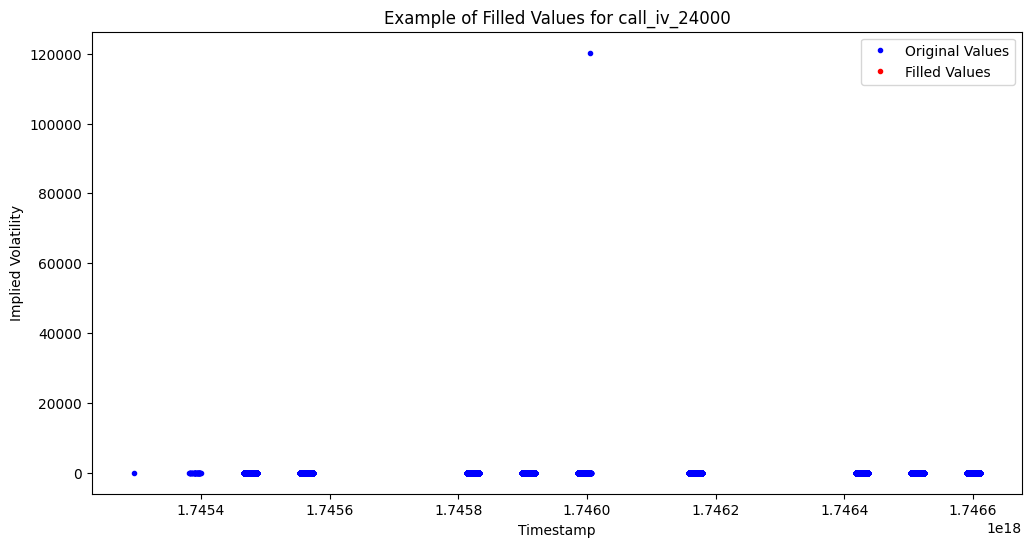

In [20]:
# Apply to validation set
val_pred = predict_iv(val_df)

# Calculate MSE only on originally masked validation points
mse_vals = []
for col in iv_columns:
    if col in val_df.columns and col in val_pred.columns:
        # Focus only on points that were originally missing
        mask = val_df[col].isna() & val_pred[col].notna()
        if mask.any():
            se = (val_df.loc[mask, col] - val_pred.loc[mask, col]) ** 2
            mse_vals.append(se.mean())

validation_mse = np.mean(mse_vals) if mse_vals else 0
print(f"Validation MSE (masked points only): {validation_mse:.12f}")

# Plot example of filled values
example_col = iv_columns[0]
filled_mask = val_df[example_col].isna() & val_pred[example_col].notna()

plt.figure(figsize=(12, 6))
plt.plot(val_df.loc[~val_df[example_col].isna(), 'timestamp'], val_df.loc[~val_df[example_col].isna(), example_col], 'b.', label='Original Values')
plt.plot(val_df.loc[filled_mask, 'timestamp'], val_pred.loc[filled_mask, example_col], 'r.', label='Filled Values')
plt.title(f'Example of Filled Values for {example_col}')
plt.xlabel('Timestamp')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

## 8. Predict on Test Set

Missing values after prediction: 0


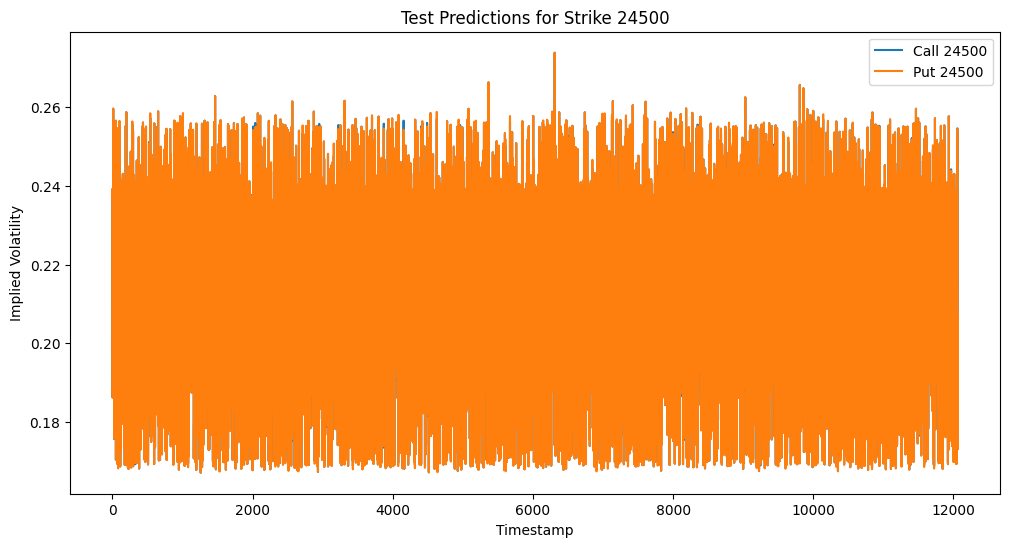

In [21]:
# Apply to test set
test_pred = predict_iv(test)

# Show missing values after prediction
print("Missing values after prediction:", test_pred[iv_columns].isna().sum().sum())

# Plot example test predictions
example_strike = list(strike_dict.keys())[5]
call_col = strike_dict[example_strike]['call']
put_col = strike_dict[example_strike]['put']

plt.figure(figsize=(12, 6))
plt.plot(test_pred['timestamp'], test_pred[call_col], label=f'Call {example_strike}')
plt.plot(test_pred['timestamp'], test_pred[put_col], label=f'Put {example_strike}')
plt.title(f'Test Predictions for Strike {example_strike}')
plt.xlabel('Timestamp')
plt.ylabel('Implied Volatility')
plt.legend()
plt.show()

## 9. Prepare Submission

In [23]:
# Prepare submission
submission = test_pred[['timestamp'] + iv_columns].copy()

# Verify no missing values
assert submission.isna().sum().sum() == 0, "Missing values detected"
submission.to_csv('submission.csv', index=False)

print("\nFinal Submission Preview:")
display(submission.head())
print(f"\nSubmission shape: {submission.shape}")
print(f"Validation MSE: {validation_mse:.12f}")


Final Submission Preview:


,timestamp,call_iv_24000,call_iv_24100,call_iv_24200,call_iv_24300,call_iv_24400,call_iv_24500,call_iv_24600,call_iv_24700,call_iv_24800,...,put_iv_24100,put_iv_24200,put_iv_24300,put_iv_24400,put_iv_24500,put_iv_24600,put_iv_24700,put_iv_24800,put_iv_24900,put_iv_25000
0,0,0.280939,0.271242,0.261544,0.251847,0.242149,0.237268,0.232436,0.227692,0.222997,...,0.271242,0.261544,0.251847,0.242149,0.237268,0.232337,0.227692,0.222997,0.227318,0.234169
1,1,0.270738,0.269205,0.258893,0.251884,0.244875,0.239212,0.233548,0.228209,0.229063,...,0.269205,0.258893,0.251884,0.244875,0.239212,0.233548,0.228209,0.229063,0.229917,0.239218
2,2,0.262454,0.251695,0.238958,0.226913,0.214869,0.204580,0.194604,0.188052,0.184360,...,0.250309,0.238958,0.226913,0.214869,0.204580,0.194612,0.188052,0.184360,0.180668,0.181346
3,3,0.241888,0.231196,0.220505,0.210733,0.198602,0.186190,0.176292,0.166394,0.161561,...,0.231196,0.220505,0.210733,0.198602,0.186190,0.176292,0.166394,0.161561,0.166528,0.171495
4,4,0.235328,0.229339,0.223001,0.214126,0.206806,0.199485,0.192603,0.187709,0.182814,...,0.229339,0.223698,0.214126,0.206806,0.199485,0.192603,0.187709,0.182814,0.177920,0.177038



Submission shape: (12065, 43)
Validation MSE: 0.000000000000


## 10. Volatility Smile Visualization

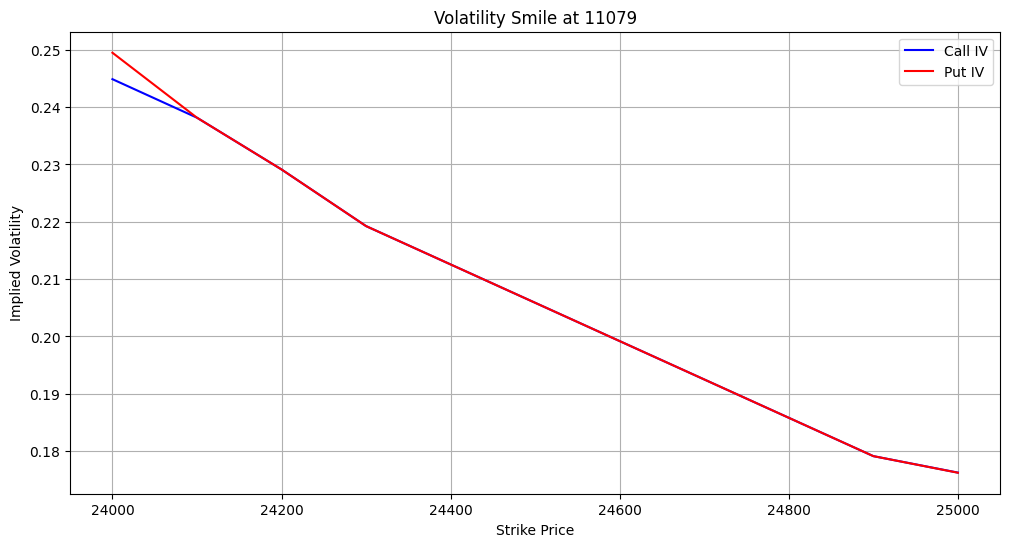

In [24]:
# Select a random timestamp to visualize
sample_time = test_pred['timestamp'].sample(1).iloc[0]
sample_row = test_pred[test_pred['timestamp'] == sample_time]

# Extract call and put IVs
call_ivs = []
put_ivs = []
strikes = []

for strike in strike_dict.keys():
    call_col = strike_dict[strike]['call']
    put_col = strike_dict[strike]['put']
    
    if call_col in sample_row.columns and put_col in sample_row.columns:
        call_ivs.append(sample_row[call_col].values[0])
        put_ivs.append(sample_row[put_col].values[0])
        strikes.append(float(strike))

# Sort by strike
sorted_idx = np.argsort(strikes)
strikes = np.array(strikes)[sorted_idx]
call_ivs = np.array(call_ivs)[sorted_idx]
put_ivs = np.array(put_ivs)[sorted_idx]

# Plot volatility smile
plt.figure(figsize=(12, 6))
plt.plot(strikes, call_ivs, 'b-', label='Call IV')
plt.plot(strikes, put_ivs, 'r-', label='Put IV')
plt.title(f'Volatility Smile at {sample_time}')
plt.xlabel('Strike Price')
plt.ylabel('Implied Volatility')
plt.legend()
plt.grid()
plt.show()